In [1]:
import numpy as np
import pandas as pd
import re
import warnings
warnings.simplefilter("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
# plt.rcdefaults()
mpl.style.use('additional')

from itertools import product
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit, StratifiedKFold, PredefinedSplit
from sklearn.metrics import classification_report, confusion_matrix, log_loss
from scipy import sparse
from xgboost import XGBClassifier
from pylightgbm.models import GBMClassifier
os.environ['LIGHTGBM_EXEC'] = '/Users/Terence/Develop/bin/lightgbm'

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Warm-Up

In [2]:
def add_features(df):
    fmt = lambda s: s.replace("\u00a0", "").strip().lower()
    df["photo_count"] = df["photos"].apply(len)
    df["street_address"] = df['street_address'].apply(fmt)
    df["display_address"] = df["display_address"].apply(fmt)
    df["desc_wordcount"] = df["description"].apply(str.split).apply(len)
    df["pricePerBed"] = df['price'] / df['bedrooms']
    df["pricePerBath"] = df['price'] / df['bathrooms']
    df["pricePerRoom"] = df['price'] / (df['bedrooms'] + df['bathrooms'])
    df["bedPerBath"] = df['bedrooms'] / df['bathrooms']
    df["bedBathDiff"] = df['bedrooms'] - df['bathrooms']
    df["bedBathSum"] = df["bedrooms"] + df['bathrooms']
    df["bedsPerc"] = df["bedrooms"] / (df['bedrooms'] + df['bathrooms'])

    df = df.fillna(-1).replace(np.inf, -1)
    return df


def factorize(df1, df2, column):
    ps = df1[column].append(df2[column])
    factors = ps.factorize()[0]
    df1[column] = factors[:len(df1)]
    df2[column] = factors[len(df1):]
    return df1, df2


def get_entry_count_and_designate_single_observations(df1, df2, column):
    ps = df1[column].append(df2[column])
    grouped = ps.groupby(ps).size().rename(column + "_entry_count")
    df1 = df1.join(grouped, on=column, how="left")
    df2 = df2.join(grouped, on=column, how="left")
    df1.loc[df1[column + "_entry_count"] <= 1, column] = -1
    df2.loc[df2[column + "_entry_count"] <= 1, column] = -1
    return df1, df2


def hcc_encode(train_df, test_df, variable, target, prior_prob, k, f=1, g=1, r_k=None, update_df=None):
    """
    See "A Preprocessing Scheme for High-Cardinality Categorical Attributes in
    Classification and Prediction Problems" by Daniele Micci-Barreca
    """
    hcc_name = "_".join(["hcc", variable, target])

    grouped = train_df.groupby(variable)[target].agg({"size": "size", "mean": "mean"})
    grouped["lambda"] = 1 / (g + np.exp((k - grouped["size"]) / f))
    grouped[hcc_name] = grouped["lambda"] * grouped["mean"] + (1 - grouped["lambda"]) * prior_prob

    df = test_df[[variable]].join(grouped, on=variable, how="left")[hcc_name].fillna(prior_prob)
    if r_k: df *= np.random.uniform(1 - r_k, 1 + r_k, len(test_df))     # Add uniform noise. Not mentioned in original paper

    if update_df is None: update_df = test_df
    if hcc_name not in update_df.columns: update_df[hcc_name] = np.nan
    update_df.update(df)
    return


def create_binary_features(df):
    bows = {
        "dogs": ("dogs", "dog"),
        "cats": ("cats",),
        "nofee": ("no fee", "no-fee", "no  fee", "nofee", "no_fee"),
        "lowfee": ("reduced_fee", "low_fee", "reduced fee", "low fee"),
        "furnished": ("furnished",),
        "parquet": ("parquet", "hardwood"),
        "concierge": ("concierge", "doorman", "housekeep", "in_super"),
        "prewar": ("prewar", "pre_war", "pre war", "pre-war"),
        "laundry": ("laundry", "lndry"),
        "health": ("health", "gym", "fitness", "training"),
        "transport": ("train", "subway", "transport"),
        "parking": ("parking",),
        "utilities": ("utilities", "heat water", "water included")
    }

    def indicator(bow):
        return lambda s: int(any([x in s for x in bow]))

    features = df["features"].apply(lambda f: " ".join(f).lower())   # convert features to string
    for key in bows:
        df["feature_" + key] = features.apply(indicator(bows[key]))

    return df
    
    
# Load data
X_train = pd.read_json("train.json").sort_values(by="listing_id")
X_test = pd.read_json("test.json").sort_values(by="listing_id")

# Make target integer, one hot encoded, calculate target priors
X_train = X_train.replace({"interest_level": {"low": 0, "medium": 1, "high": 2}})
X_train = X_train.join(pd.get_dummies(X_train["interest_level"], prefix="pred").astype(int))
prior_0, prior_1, prior_2 = X_train[["pred_0", "pred_1", "pred_2"]].mean()

# Add common features
X_train = add_features(X_train)
X_test = add_features(X_test)

# Get entry counts for categorical features and special designation for building_ids, manager_ids, display_address with only 1 observation
for col in ('building_id', 'manager_id', 'display_address'):
    X_train, X_test = get_entry_count_and_designate_single_observations(X_train, X_test, col)

# High-Cardinality Categorical encoding
skf = StratifiedKFold(5)
attributes = product(("building_id", "manager_id"), zip(("pred_1", "pred_2"), (prior_1, prior_2)))
for variable, (target, prior) in attributes:
    hcc_encode(X_train, X_test, variable, target, prior, k=5, r_k=None)
    for train, test in skf.split(np.zeros(len(X_train)), X_train['interest_level']):
        hcc_encode(X_train.iloc[train], X_train.iloc[test], variable, target, prior, k=5, r_k=0.01, update_df=X_train)

# Factorize building_id, display_address, manager_id, street_address
for col in ('building_id', 'display_address', 'manager_id', 'street_address'):
    X_train, X_test = factorize(X_train, X_test, col)

# Create binarized features
X_train = create_binary_features(X_train)
X_test = create_binary_features(X_test)

# save
X_train = X_train.sort_index(axis=1).sort_index()
X_test = X_test.sort_index(axis=1).sort_index()
columns_to_drop = ["photos", "pred_0","pred_1", "pred_2", "created"]
X_train.drop(columns_to_drop, axis=1, errors="ignore", inplace=True)
X_test.drop(columns_to_drop, axis=1, errors="ignore", inplace=True)

In [3]:
from itertools import chain

def features_cleanup_star(x):
    return list(chain.from_iterable(re.sub(r'\s*\*+\s*\**\s*', r'*', i).strip('*').split('*') for i in x))

def process_features(df):
    df['features_clean'] = df['features']\
                    .apply(lambda x: ' '.join([re.sub(r'\W', '', i) for i in x]).lower())

    df.loc[df.features_clean.str.contains('\*'), 'features_clean'] = \
            df.loc[df.features_clean.str.contains('\*'), 'features']\
                    .apply(features_cleanup_star)\
                    .apply(lambda x: ' '.join([re.sub(r'\W', '', i) for i in x]).lower())
                
process_features(X_train)
process_features(X_test)

countvec_features = CountVectorizer(stop_words='english', max_features=200)
countvec_features.fit(X_train['features_clean'].tolist() + X_test['features_clean'].tolist())
X_train_features = countvec_features.transform(X_train['features_clean'])
X_test_features = countvec_features.transform(X_test['features_clean'])

countvec_desc = CountVectorizer(stop_words='english', max_features=200)
countvec_desc.fit(X_train['description'].tolist() + X_test['description'].tolist())
X_train_desc = countvec_desc.transform(X_train['description'])
X_test_desc = countvec_desc.transform(X_test['description'])

columns_to_drop = ["description", "features", "features_clean"]
X_train.drop(columns_to_drop, axis=1, errors="ignore", inplace=True)
X_test.drop(columns_to_drop, axis=1, errors="ignore", inplace=True)

In [4]:
X_train.head()

,bathrooms,bedBathDiff,bedBathSum,bedPerBath,bedrooms,bedsPerc,building_id,building_id_entry_count,desc_wordcount,display_address,...,listing_id,longitude,manager_id,manager_id_entry_count,photo_count,price,pricePerBath,pricePerBed,pricePerRoom,street_address
4,1.000000,0.000000,2.000000,1.000000,1,0.500000,4181,8,75,3667,...,7170325,-73.953900,787,294,12,2400,2400.000000,2400.000000,1200.000000,9650
6,1.000000,1.000000,3.000000,2.000000,2,0.666667,356,110,129,3165,...,7092344,-73.972200,1133,64,6,3800,3800.000000,1900.000000,1266.666667,7913
9,1.000000,1.000000,3.000000,2.000000,2,0.666667,255,158,117,25,...,7158677,-73.962500,213,265,6,3495,3495.000000,1747.500000,1165.000000,375
10,1.500000,1.500000,4.500000,2.000000,3,0.666667,5177,5,93,1143,...,7211212,-73.942500,174,235,5,3000,2000.000000,1000.000000,666.666667,12769
15,1.000000,-1.000000,1.000000,0.000000,0,0.000000,53,227,39,256,...,7225292,-73.974300,715,135,4,2795,2795.000000,-1.000000,2795.000000,1323


In [5]:
X_train.columns

Index(['bathrooms', 'bedBathDiff', 'bedBathSum', 'bedPerBath', 'bedrooms',
       'bedsPerc', 'building_id', 'building_id_entry_count', 'desc_wordcount',
       'display_address', 'display_address_entry_count', 'feature_cats',
       'feature_concierge', 'feature_dogs', 'feature_furnished',
       'feature_health', 'feature_laundry', 'feature_lowfee', 'feature_nofee',
       'feature_parking', 'feature_parquet', 'feature_prewar',
       'feature_transport', 'feature_utilities', 'hcc_building_id_pred_1',
       'hcc_building_id_pred_2', 'hcc_manager_id_pred_1',
       'hcc_manager_id_pred_2', 'interest_level', 'latitude', 'listing_id',
       'longitude', 'manager_id', 'manager_id_entry_count', 'photo_count',
       'price', 'pricePerBath', 'pricePerBed', 'pricePerRoom',
       'street_address'],
      dtype='object')

In [6]:
test_fold = np.zeros(X_train.shape[0])
for idx, (train, test) in enumerate(StratifiedKFold(3, shuffle=True).split(X_train, X_train.interest_level)):
    test_fold[test] = idx
    
ps = PredefinedSplit(test_fold)
# for train_index, test_index in ps.split():
#    print("TRAIN:", train_index, "TEST:", test_index)

## Basic Model

In [30]:
# base_cols = X_train.loc[:, :'street_address'].drop('interest_level', axis=1).columns
base_cols = ['bathrooms', 'bedBathDiff', 'bedBathSum', 'bedPerBath', 'bedrooms',
            'bedsPerc', 'desc_wordcount', 'display_address', 
            'feature_cats', 'feature_concierge', 'feature_dogs', 'feature_furnished',
            'feature_health', 'feature_laundry', 'feature_lowfee', 'feature_nofee',
            'feature_parking', 'feature_parquet', 'feature_prewar',
            'feature_transport', 'feature_utilities', 'latitude', 'longitude', 'photo_count',
            'price', 'pricePerBath', 'pricePerBed', 'pricePerRoom',
            'hcc_building_id_pred_1', 'hcc_building_id_pred_2', 'hcc_manager_id_pred_1', 'hcc_manager_id_pred_2',
            'building_id_entry_count', 'manager_id_entry_count', 'display_address_entry_count',
            'building_id', 'manager_id', 'display_address', 'street_address', 'listing_id',
            ]

In [31]:
base_lbgm = GBMClassifier(application='multiclass', metric='multi_logloss', learning_rate=0.1, num_iterations=100, num_class=3, early_stopping_round=10, verbose=False)
cross_val_score(base_lbgm, X_train[base_cols], X_train.interest_level, scoring='neg_log_loss', cv=ps, n_jobs=-1)

array([-0.54725072, -0.54690345, -0.55198297])

## Text Feature Model

In [10]:
X_train_text_combined = sparse.hstack([X_train_features, X_train_desc]).tocsr()
text_sgd = SGDClassifier(alpha=1e-3, n_jobs=-1, loss='log').fit(X_train_text_combined, X_train.interest_level)
cross_val_score(text_sgd, X_train_text_combined, X_train.interest_level, cv=ps, n_jobs=-1)

array([ 0.68305878,  0.68093125,  0.69221884])

# With Images

## Loading and Averaging

In [11]:
images = pd.read_csv('images.csv', index_col=0)

In [12]:
images.head()

,path,listing_id,image_num,width,height,b_med,g_med,r_med,b_mean,g_mean,...,v_mean,h_std,s_std,v_std,h_min,s_min,v_min,h_max,s_max,v_max
0,images/6829815/6829815_0d13451ab112afe1d89c17d...,6829815,6829815_0d13451ab112afe1d89c17d3a87eb4d6.jpg,225,28,234.000000,236.000000,235.000000,226.018095,226.862698,...,232.434762,5.305245,3.912670,10.080517,0,0,127,173,90,255
1,images/6829815/6829815_9e5670a9b05dee534aa56d8...,6829815,6829815_9e5670a9b05dee534aa56d800f0befa7.jpg,210,5,233.000000,236.000000,236.000000,228.142857,233.699048,...,236.384762,0.343332,0.047081,0.090524,0,0,211,173,52,243
2,images/6829815/6829815_59f94daf6da125212934faa...,6829815,6829815_59f94daf6da125212934faa7b5c31cdd.jpg,261,261,115.000000,147.000000,168.000000,133.759384,148.703058,...,163.801295,4.342565,6.853580,8.223145,0,0,0,179,255,255
3,images/6829815/6829815_6d80a1757880aea29f1e8e3...,6829815,6829815_6d80a1757880aea29f1e8e3514731c22.jpg,250,300,69.000000,141.500000,187.000000,86.546400,149.151827,...,189.341240,8.714660,12.787286,4.325934,0,0,1,177,255,255
4,images/6829860/6829860_5526023a50900dd743d77c0...,6829860,6829860_5526023a50900dd743d77c0252882412.jpg,250,40,250.000000,250.000000,249.500000,248.749600,249.128700,...,249.964400,7.651652,2.343945,1.863532,0,0,176,177,73,255


In [13]:
images_by_listing = images.groupby('listing_id').mean()

In [50]:
images_by_listing.head()

,width,height,b_med,g_med,r_med,b_mean,g_mean,r_mean,b_std,g_std,...,v_mean,h_std,s_std,v_std,h_min,s_min,v_min,h_max,s_max,v_max
listing_id,,,,,,,,,,,,,,,,,,,,,
6811957,468.800000,597.200000,182.200000,184.200000,185.600000,174.315374,178.306747,181.162631,9.746320,42.422490,...,183.314949,8.765036,11.198956,9.100097,0.000000,0.000000,23.800000,178.200000,230.400000,255.000000
6811958,455.000000,566.000000,172.812500,184.500000,181.250000,162.508884,167.967780,170.705353,16.971484,57.626413,...,176.997221,8.875169,7.512379,16.853477,0.000000,0.000000,10.250000,134.250000,191.250000,254.500000
6811960,354.666667,429.333333,115.750000,135.000000,146.666667,123.327383,139.288331,148.785269,21.579429,51.362159,...,153.797878,17.133040,10.244183,17.189939,0.000000,0.666667,21.666667,178.166667,224.166667,255.000000
6811964,442.400000,527.200000,133.200000,146.400000,154.800000,132.941554,142.421283,148.863236,13.172617,55.980484,...,150.596169,12.578563,6.576471,11.099417,0.000000,0.000000,0.000000,178.600000,255.000000,255.000000
6811965,370.500000,600.000000,65.500000,82.500000,93.250000,71.968565,86.685333,94.369002,17.624676,39.574643,...,95.877384,14.138838,15.620368,14.902253,0.000000,0.000000,2.000000,177.000000,255.000000,255.000000


In [69]:
images_by_listing.describe()

,width,height,b_med,g_med,r_med,b_mean,g_mean,r_mean,b_std,g_std,...,v_mean,h_std,s_std,v_std,h_min,s_min,v_min,h_max,s_max,v_max
count,114773.000000,114773.000000,114773.000000,114773.000000,114773.000000,114773.000000,114773.000000,114773.000000,114773.000000,114773.000000,...,114773.000000,114773.000000,114773.000000,114773.000000,114773.000000,114773.000000,114773.000000,114773.000000,114773.000000,114773.000000
mean,459.476956,551.832557,133.379014,150.372478,160.488366,129.583080,144.692675,154.140367,13.935946,52.299648,...,158.613328,12.773240,11.572646,13.258602,0.033829,0.149660,10.297493,176.815712,241.151310,254.594959
std,96.579057,98.737830,32.700992,28.453160,28.321963,25.404279,22.972479,23.618436,3.205195,8.774736,...,22.766492,3.383691,3.393951,2.933638,0.461919,1.106302,11.523266,8.978313,22.897171,1.745251
min,23.000000,49.000000,0.000000,0.000000,0.000000,20.399295,25.683915,25.879293,2.844787,12.970309,...,27.319730,0.000000,0.000000,2.227611,0.000000,0.000000,0.000000,0.000000,0.000000,184.333333
25%,411.750000,509.250000,110.150000,130.450000,141.000000,111.672367,128.398204,137.652273,11.795932,46.487014,...,142.922738,10.466254,9.232092,11.325727,0.000000,0.000000,2.250000,178.000000,234.333333,255.000000
50%,463.571429,583.000000,132.300000,149.950000,160.750000,128.875182,144.032396,153.604057,13.607068,52.397158,...,158.485751,12.595804,11.328015,13.031574,0.000000,0.000000,7.000000,178.666667,253.400000,255.000000
75%,517.750000,640.000000,156.166667,170.660714,180.400000,146.981634,160.558281,170.147539,15.724170,57.977032,...,174.121918,14.940886,13.569721,14.908941,0.000000,0.000000,14.666667,179.000000,255.000000,255.000000
max,640.000000,640.000000,255.000000,255.000000,255.000000,250.953177,250.953177,252.391173,40.415867,124.264891,...,252.674937,32.382700,34.950528,40.415867,29.250000,36.800000,134.000000,179.000000,255.000000,255.000000


In [53]:
# error check
X_train.loc[~X_train.listing_id.isin(images_by_listing.index), ['listing_id', 'photo_count']].query('photo_count != 0')

,listing_id,photo_count


In [14]:
# join and fill in null values
X_train = X_train.join(images_by_listing, on='listing_id')
X_train.loc[X_train.width.isnull(), images_by_listing.columns] = images_by_listing.mean()
X_test = X_test.join(images_by_listing, on='listing_id')
X_test.loc[X_test.width.isnull(), images_by_listing.columns] = images_by_listing.mean()

## A Model with Combined Features

In [15]:
all_lbgm = GBMClassifier(application='multiclass', metric='multi_logloss', learning_rate=0.1, num_iterations=100, num_class=3, early_stopping_round=10, verbose=False)
cross_val_score(all_lbgm, X_train.drop('interest_level', axis=1), X_train.interest_level, scoring='neg_log_loss', cv=ps, n_jobs=-1)
# lbgm.fit(X_train.drop('interest_level', axis=1), X_train.interest_level)

array([-0.56424496, -0.55649646, -0.56642971])

It goes to show that directly combining features does not lead to gains.

## A Model with Image Features Only

In [16]:
image_lbgm = GBMClassifier(application='multiclass', metric='multi_logloss', learning_rate=0.1, num_iterations=100, num_class=3, early_stopping_round=10, verbose=False)
cross_val_score(image_lbgm, X_train[images_by_listing.columns], X_train.interest_level, scoring='neg_log_loss', cv=ps, n_jobs=-1)

array([-0.74926313, -0.75084918, -0.74781419])

## Stacked Model

In [17]:
y_train_pred_cv_base_lbgm = cross_val_predict(base_lbgm, X_train[base_cols], X_train.interest_level, n_jobs=-1, method='predict_proba')
y_train_pred_cv_text_sgd = cross_val_predict(text_sgd, X_train_text_combined, X_train.interest_level, n_jobs=-1, method='predict_proba')
y_train_pred_cv_image_lbgm = cross_val_predict(image_lbgm, X_train[images_by_listing.columns], X_train.interest_level, n_jobs=-1, method='predict_proba')

Try plain averaging.

In [47]:
y_train_pred_cv_l1_avg = y_train_pred_cv_base_lbgm + y_train_pred_cv_text_sgd + y_train_pred_cv_image_lbgm
y_train_pred_cv_l1_avg = y_train_pred_cv_l1_avg/y_train_pred_cv_l1_avg.sum(axis=1)[:, np.newaxis]
log_loss(X_train.interest_level, y_train_pred_cv_l1_avg)

0.64269002796323071

In [18]:
X_train_feature_l1 = np.hstack([y_train_pred_cv_base_lbgm, y_train_pred_cv_text_sgd, y_train_pred_cv_image_lbgm])

Try `LogisticRegression`.

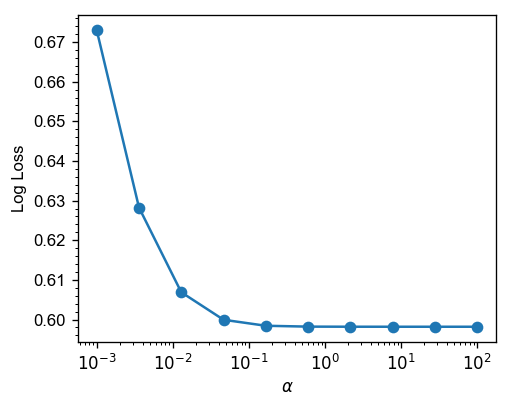

In [28]:
l1_lr = GridSearchCV(LogisticRegression(), {'C': np.logspace(-3, 2, 10)}, scoring='neg_log_loss', n_jobs=-1, cv=ps).fit(X_train_feature_l1, X_train.interest_level)
l1_lr_cv_results = pd.DataFrame(l1_lr.cv_results_)
plt.semilogx(l1_lr_cv_results['param_C'], -l1_lr_cv_results['mean_test_score'], '-o')
plt.xlabel(r'$\alpha$')
plt.ylabel('Log Loss')

Try `GBMClassifier`.

In [19]:
l1_lbgm = GBMClassifier(application='multiclass', metric='multi_logloss', learning_rate=0.1, num_iterations=100, num_class=3, early_stopping_round=10, verbose=False)
cross_val_score(l1_lbgm, X_train_feature_l1, X_train.interest_level, scoring='neg_log_loss', cv=ps, n_jobs=-1)

array([-0.59409027, -0.58144605, -0.59429013])

## More Base Models  to Stack

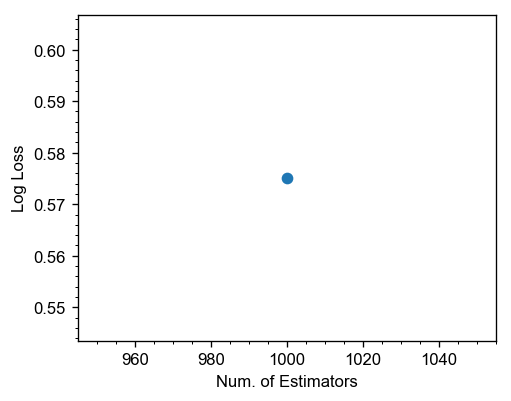

In [57]:
base_rf = GridSearchCV(RandomForestClassifier(), {'n_estimators': [1000]}, scoring='neg_log_loss', n_jobs=-1, cv=ps)
base_rf.fit(X_train[base_cols], X_train.interest_level)
base_rf_cv_results = pd.DataFrame(base_rf.cv_results_)
plt.plot(base_rf_cv_results['param_n_estimators'], -base_rf_cv_results['mean_test_score'], '-o')
plt.xlabel('Num. of Estimators')
plt.ylabel('Log Loss')

In [59]:
base_rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
y_train_pred_cv_base_rf = cross_val_predict(base_rf, X_train[base_cols], X_train.interest_level, n_jobs=-1, method='predict_proba')

In [60]:
X_train_feature_l1_1 = np.hstack([y_train_pred_cv_base_lbgm[:, :-1], y_train_pred_cv_text_sgd[:, :-1], y_train_pred_cv_image_lbgm[:, :-1], y_train_pred_cv_base_rf[:, :-1]])
l1_lbgm = GBMClassifier(application='multiclass', metric='multi_logloss', learning_rate=0.1, num_iterations=100, num_class=3, early_stopping_round=10, verbose=False)
cross_val_score(l1_lbgm, X_train_feature_l1_1, X_train.interest_level, scoring='neg_log_loss', cv=ps, n_jobs=-1)

array([-0.58964858, -0.58173647, -0.59332571])

Looks like my ensembles need more work.